# Age approximation from customers photographs

This project aims at evaluating a person's age from a photo taken at a supermarket checkout using a neural network in order to analyze purchases and offer products that may interest buyers in particular age groups and to monitor clerks selling alcohol.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
from tensorflow.keras.optimizers import Adam
import pandas as pd
from matplotlib import pyplot as plt 

# 1. Exploratory data analysis

In [2]:
path='/datasets/faces/'

In [3]:
labels = pd.read_csv(path+'labels.csv')

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


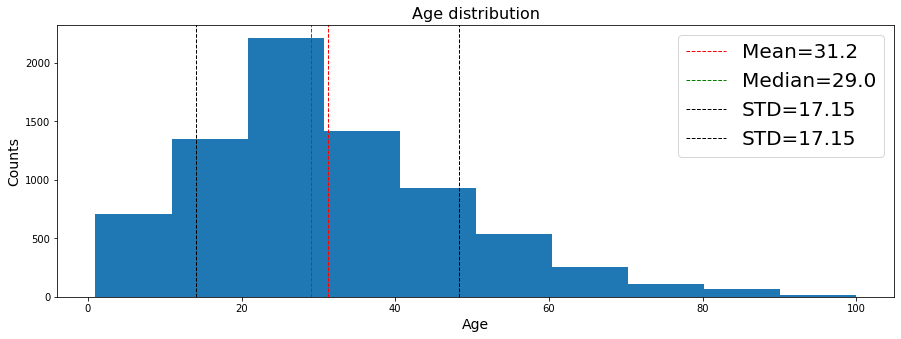

In [6]:
plt.figure(figsize=(15,5))
plt.hist(labels['real_age'], bins=10)
age_mean=labels['real_age'].mean()
age_median=labels['real_age'].median()
age_std=labels['real_age'].std()
plt.axvline(age_mean, color='r', linestyle='dashed', linewidth=1, label='Mean='+str(round(age_mean,2)))
plt.axvline(age_median, color='g', linestyle='dashed', linewidth=1, label='Median='+str(round(age_median,2)))
plt.axvline(age_mean-age_std, color='K', linestyle='dashed', linewidth=1, label='STD='+str(round(age_std,2)))
plt.axvline(age_mean+age_std, color='K', linestyle='dashed', linewidth=1)
plt.title('Age distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend(fontsize=14)


In [7]:
features, target=next(train_gen_flow)

In [8]:
features.shape

(32, 224, 224, 3)

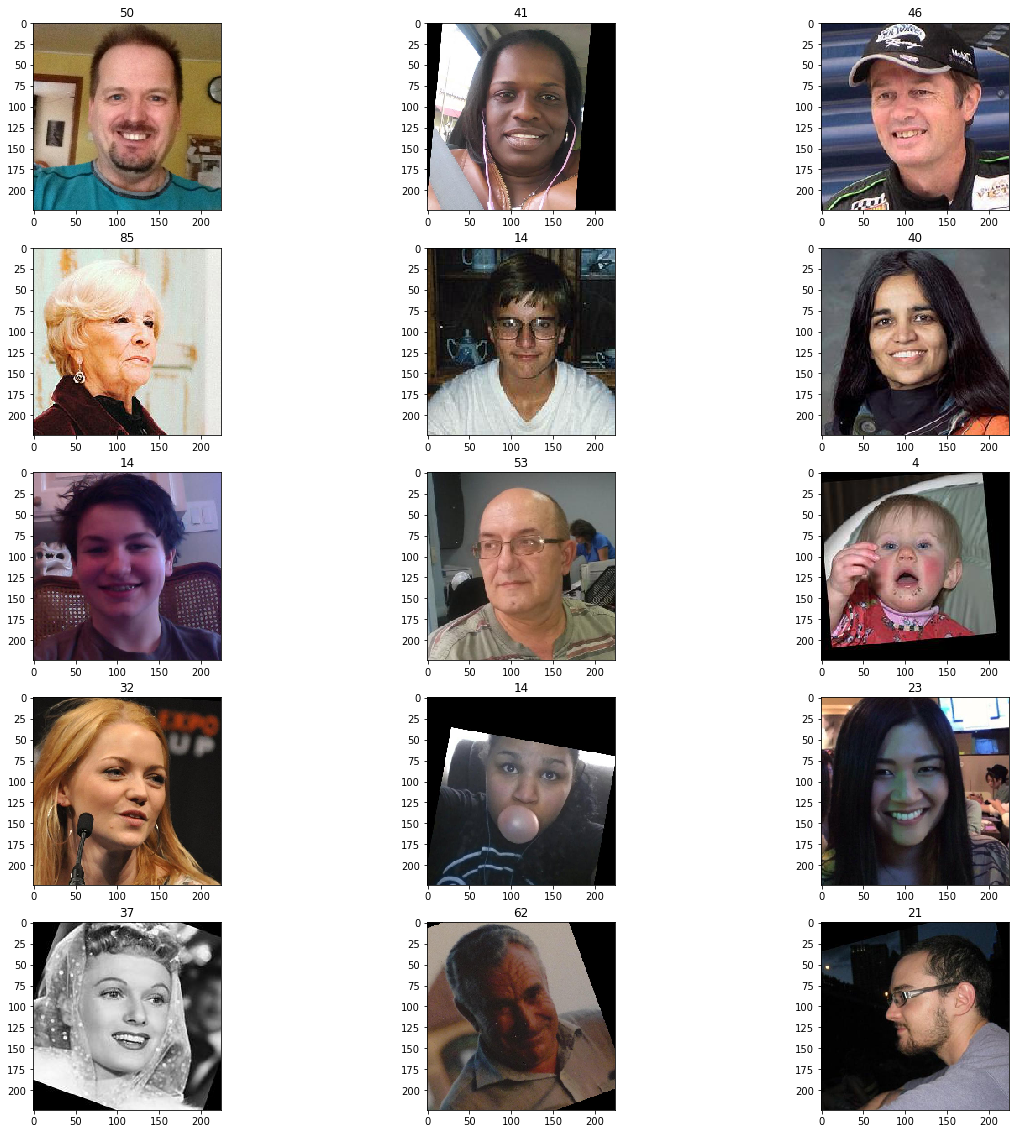

In [10]:
plt.subplots(5,3, figsize=(20,20))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    plt.imshow(features[i])
    plt.title(target[i])

- The age distribution is skewed and gaussian-like, with higher density in the 20-30 decade.
- The mean and median are around the age of 30.
- Some of the photos are rotated, some are grayscaled or dark
- It could be beneficial to try rotation, brightness or channel augmentations
- Since the data has no outliers and we don't want the model to treat the gaussian tail of older ages as outliers, it may be better to use MAE loss than MSE as it doesn't square the errors. 

# 2. Model training

```python

def load_train(path):
    path_labels=path+'labels.csv'
    labels = pd.read_csv(path_labels)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path+'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345) 

    return train_datagen_flow

def load_test(path):
    path_labels=path+'labels.csv'
    labels = pd.read_csv(path_labels)   
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path+'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345) 

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))  
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mae', 
              metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps,
            verbose=2) 

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/8
2021-02-13 10:44:18.770012: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-02-13 10:44:23.044624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 152s - loss: 10.6865 - mae: 10.6874 - val_loss: 23.9337 - val_mae: 23.9415
Epoch 2/8
178/178 - 40s - loss: 6.6796 - mae: 6.6797 - val_loss: 20.3692 - val_mae: 20.3523
Epoch 3/8
178/178 - 40s - loss: 5.4569 - mae: 5.4574 - val_loss: 15.5587 - val_mae: 15.5200
Epoch 4/8
178/178 - 40s - loss: 4.8547 - mae: 4.8547 - val_loss: 8.0006 - val_mae: 7.9806
Epoch 5/8
178/178 - 40s - loss: 4.1776 - mae: 4.1774 - val_loss: 6.8937 - val_mae: 6.8976
Epoch 6/8
178/178 - 40s - loss: 3.8749 - mae: 3.8752 - val_loss: 6.2880 - val_mae: 6.2723
Epoch 7/8
178/178 - 39s - loss: 3.5073 - mae: 3.5075 - val_loss: 6.8416 - val_mae: 6.8421
Epoch 8/8
178/178 - 40s - loss: 3.2550 - mae: 3.2550 - val_loss: 6.5002 - val_mae: 6.5271

```

# 3. Trained model analysis

- The model achieved MAE=6.52 in 8 epochs and could probabaly achieved a little smaller error in longer training time.
- It uses Adam optimizer with low learning rate of 0.0001 and MAE loss.
- Augmentations resulted in larger error and weren't used in the final model
- The MAE is almost half a decade and it's implications depend on how we define customerss' age groups. 6.5 years could be the difference between a child to a youngster or between a minor to an adult but is less significant in older ages. 
- The MAE is only 21% of the mean value and 48% of STD 
- The system could be usefull for reccomendations for age groups of adults above 30 but is less reliable for yound customers.